In [1]:
from torch.utils.data import DataLoader

from tqdm import tqdm

import torchvision.transforms as transforms
import torchvision

import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn 
import torch

import matplotlib.pyplot as plt
import numpy as np

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <11CA4EBF-5A84-3662-A35A-A039CEE97F5E> /Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('mps')
print(f"Device selected : {device}")

Device selected : mps


# Load datasets

In [3]:
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset   = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset    = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Model Network

In [4]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3),                nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, 3),              nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 384, 3, padding=1),  nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(384, 256, 3, padding=1),  nn.ReLU(),
            nn.Conv2d(256, 256, 1),             nn.ReLU(), nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 1024),                 nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),               nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 256)
        x = self.classifier(x)
        return x

# Training

In [5]:
criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=1e-3)

In [6]:
loss_ = list()
n = len(trainloader)

for epoch in range(50):
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        # Forward
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    loss_.append(running_loss / n)
    print(f"{epoch + 1} loss : {running_loss / len(trainloader)}")


1 loss : 1.6905853461548066
2 loss : 1.2600256709890798
3 loss : 1.076572484834333
4 loss : 0.9551785144375748
5 loss : 0.8611991989521056
6 loss : 0.7881472109127563
7 loss : 0.7248051863447337
8 loss : 0.6702468793455485
9 loss : 0.6162167447199062
10 loss : 0.5685944037222359
11 loss : 0.5417570778128815
12 loss : 0.4970723693702973
13 loss : 0.4685308404996162
14 loss : 0.4364138571825534
15 loss : 0.40925303569405563
16 loss : 0.38554085752261197
17 loss : 0.3705777577884252
18 loss : 0.3486227377312483
19 loss : 0.3248400643077022
20 loss : 0.3182562705360577
21 loss : 0.30453472194528197
22 loss : 0.2853500266104784
23 loss : 0.27465874336002083
24 loss : 0.2641954131481629
25 loss : 0.25597859042329013
26 loss : inf
27 loss : 0.22899918738390324
28 loss : 0.23673730590562464
29 loss : 0.2244813471302028
30 loss : 0.21297801627675625
31 loss : 0.2133914568617592
32 loss : 0.20222996847205918
33 loss : 0.21054453959242247
34 loss : 0.1997318678362425
35 loss : 0.19783275719089713

# Result Visualization

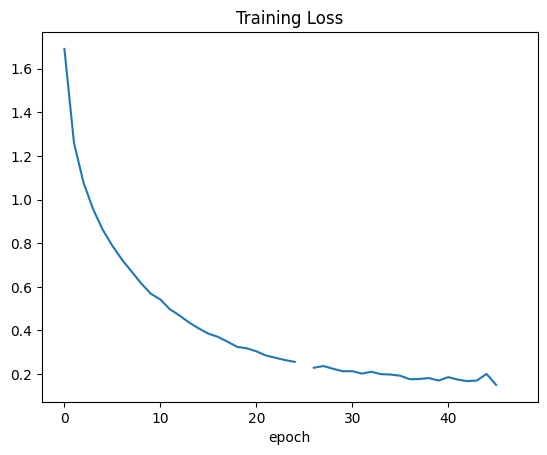

In [7]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

# Model save